In [1]:
!pip install importlib-metadata==4.13.0
!pip install POT==0.5.1
!pip install dionysus
!pip install gudhi
!pip install alphashape
!pip install zarr

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.8.0
    Uninstalling importlib-metadata-6.8.0:
      Successfully uninstalled importlib-metadata-6.8.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for POT: filename=POT-0.5.1-cp310-cp310-linux_x86_64.whl size=284991 sha256=fe93ac5244346d2ebb1a10e863c0e05ad5537d1dce0e31ac5f77eee5a9a7943d
  Stored in directory: /root/.cache/pip/wheels/d6/58/ea/7f965a8540b44cd963a1f6c9a5c0554e777eea26f5bb0b5d2d
Successfully built POT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440668 sha256=90337d6b1602f0ffa3a786fef3336e94265a436769f1887cc76aec5e05bbf71d
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191

In [2]:
import numpy as np
import dionysus as d
import matplotlib.pyplot as plt
import networkx as nx
import scipy.spatial as sp
import zarr
import gudhi as gd
import alphashape
from shapely.geometry import Polygon, mapping
from gudhi.wasserstein import wasserstein_distance as wd

In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

import os
os.chdir("/content/drive/My Drive/NASA/Fire Detection")
!ls -ltr

Mounted at /content/drive
total 12
drwx------ 2 root root 4096 Jun  6 00:50 'zzpd fire data'
drwx------ 2 root root 4096 Jun  9 01:01 'zzpd fire data 2'
drwx------ 2 root root 4096 Jul  6 01:45 'zzpd fire data 3'


In [4]:
#fname = 'zzpd fire data 2' # old dataset
fname = 'zzpd fire data 3'
rawFileList = os.listdir(fname)
print (rawFileList)
print (len(rawFileList))

['Tile_1_33_20201501711176.zarr', 'Tile_1_33_20201501801176.zarr', 'Tile_1_33_20201511406176.zarr', 'Tile_1_33_20201501811176.zarr', 'Tile_1_33_20201501701176.zarr', 'Tile_1_33_20201501756176.zarr', 'Tile_1_33_20201511436176.zarr', 'Tile_1_33_20201511416176.zarr', 'Tile_1_33_20201491716176.zarr']
9


In [5]:
channel7List = []
channel7Name = []
timeSeriesDict = {}

rawFileList = sorted(rawFileList)

for name in rawFileList:
    channelData = np.array(zarr.open(fname + '//' + name)[:, :, 0]) # select channel 7
    timeSeriesDict[name] = channelData
    channel7List.append(channelData)
    channel7Name.append(name)

print (len(channel7List))

9


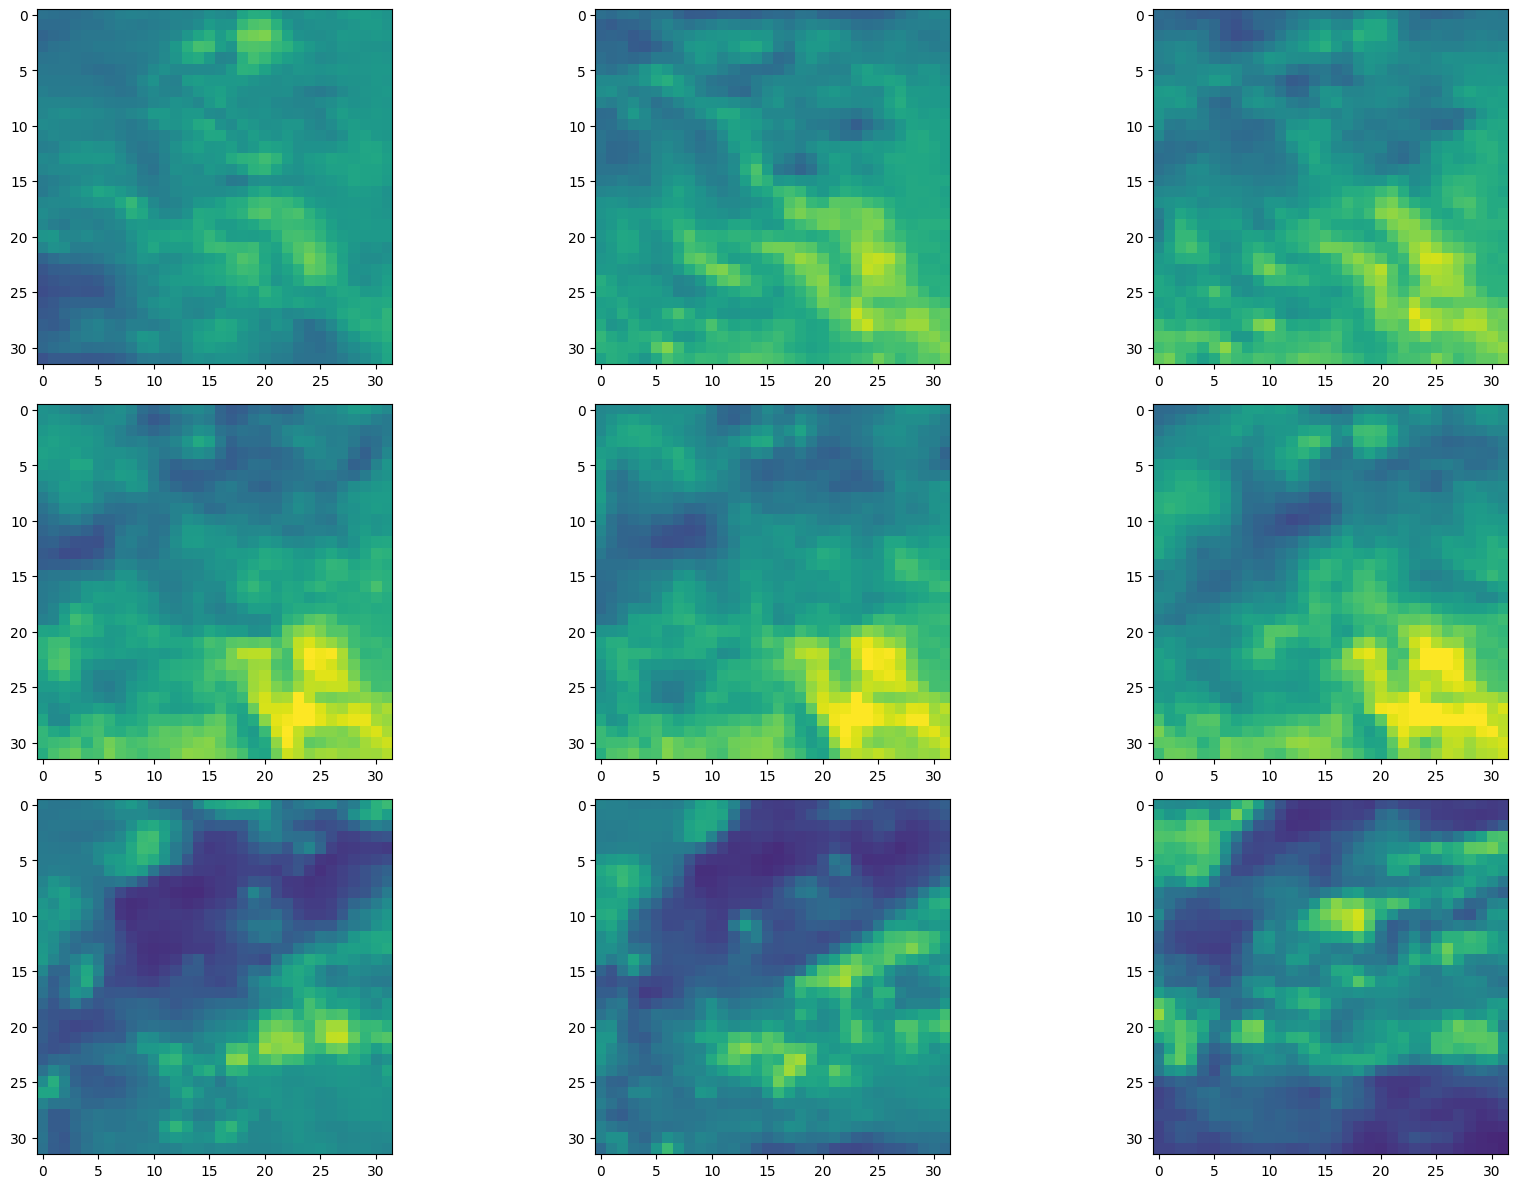

In [6]:
#nrow = 2 # old data
#ncol = 4

nrow = 3
ncol = 3

fig, axs = plt.subplots(nrow, ncol, figsize=(18, 12))

for i in range(nrow):
    for j in range(ncol):
        axs[i, j].imshow(channel7List[i* ncol + j], vmin=0, vmax=1) # vmin, vmax may change on different tiles
        #label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j], 'fire'].iloc[0]
        #axs[i, j].title.set_text('Label {}'.format(label))

plt.tight_layout()

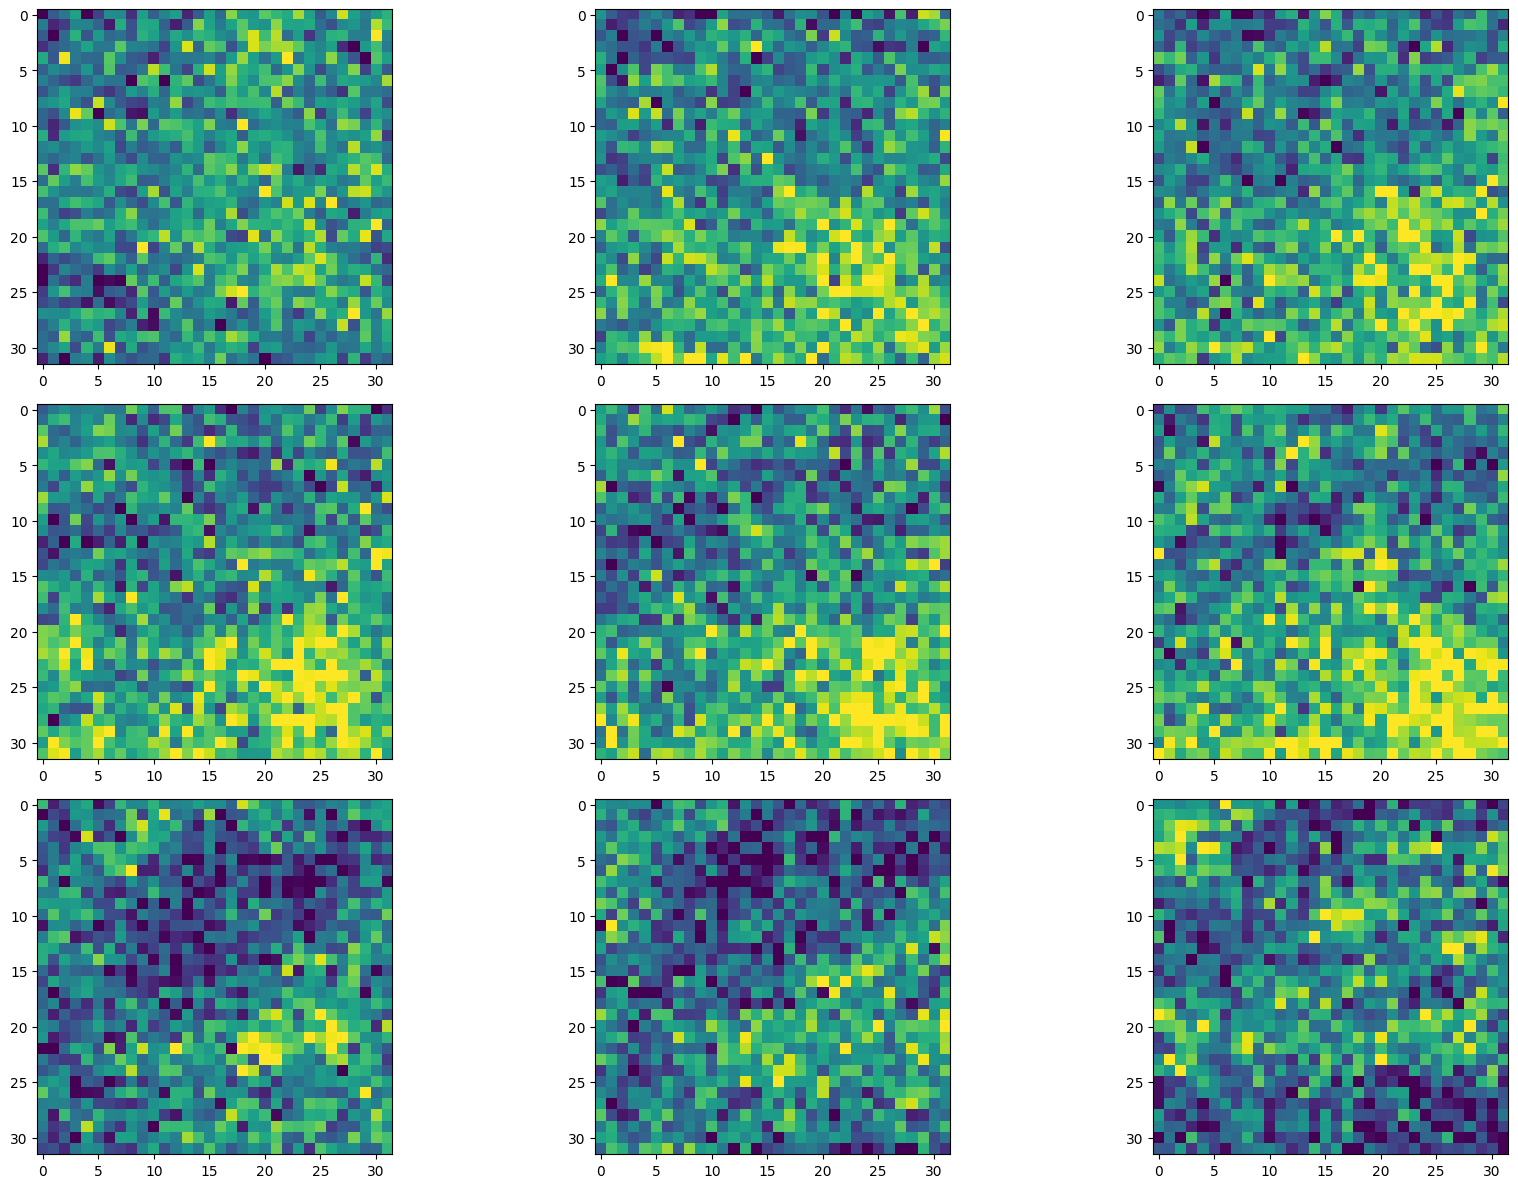

In [7]:
#nrow = 2 # old data
#ncol = 4

fig, axs = plt.subplots(nrow, ncol, figsize=(18, 12))


data_after_noise = []

for i in range(nrow):
    for j in range(ncol):
        matrix = np.random.normal(loc=0.0, scale=0.2, size=(32, 32))
        data_after_noise.append(channel7List[i* ncol + j] + matrix)
        axs[i, j].imshow(channel7List[i* ncol + j] + matrix, vmin=0, vmax=1) # Add noise

plt.tight_layout()

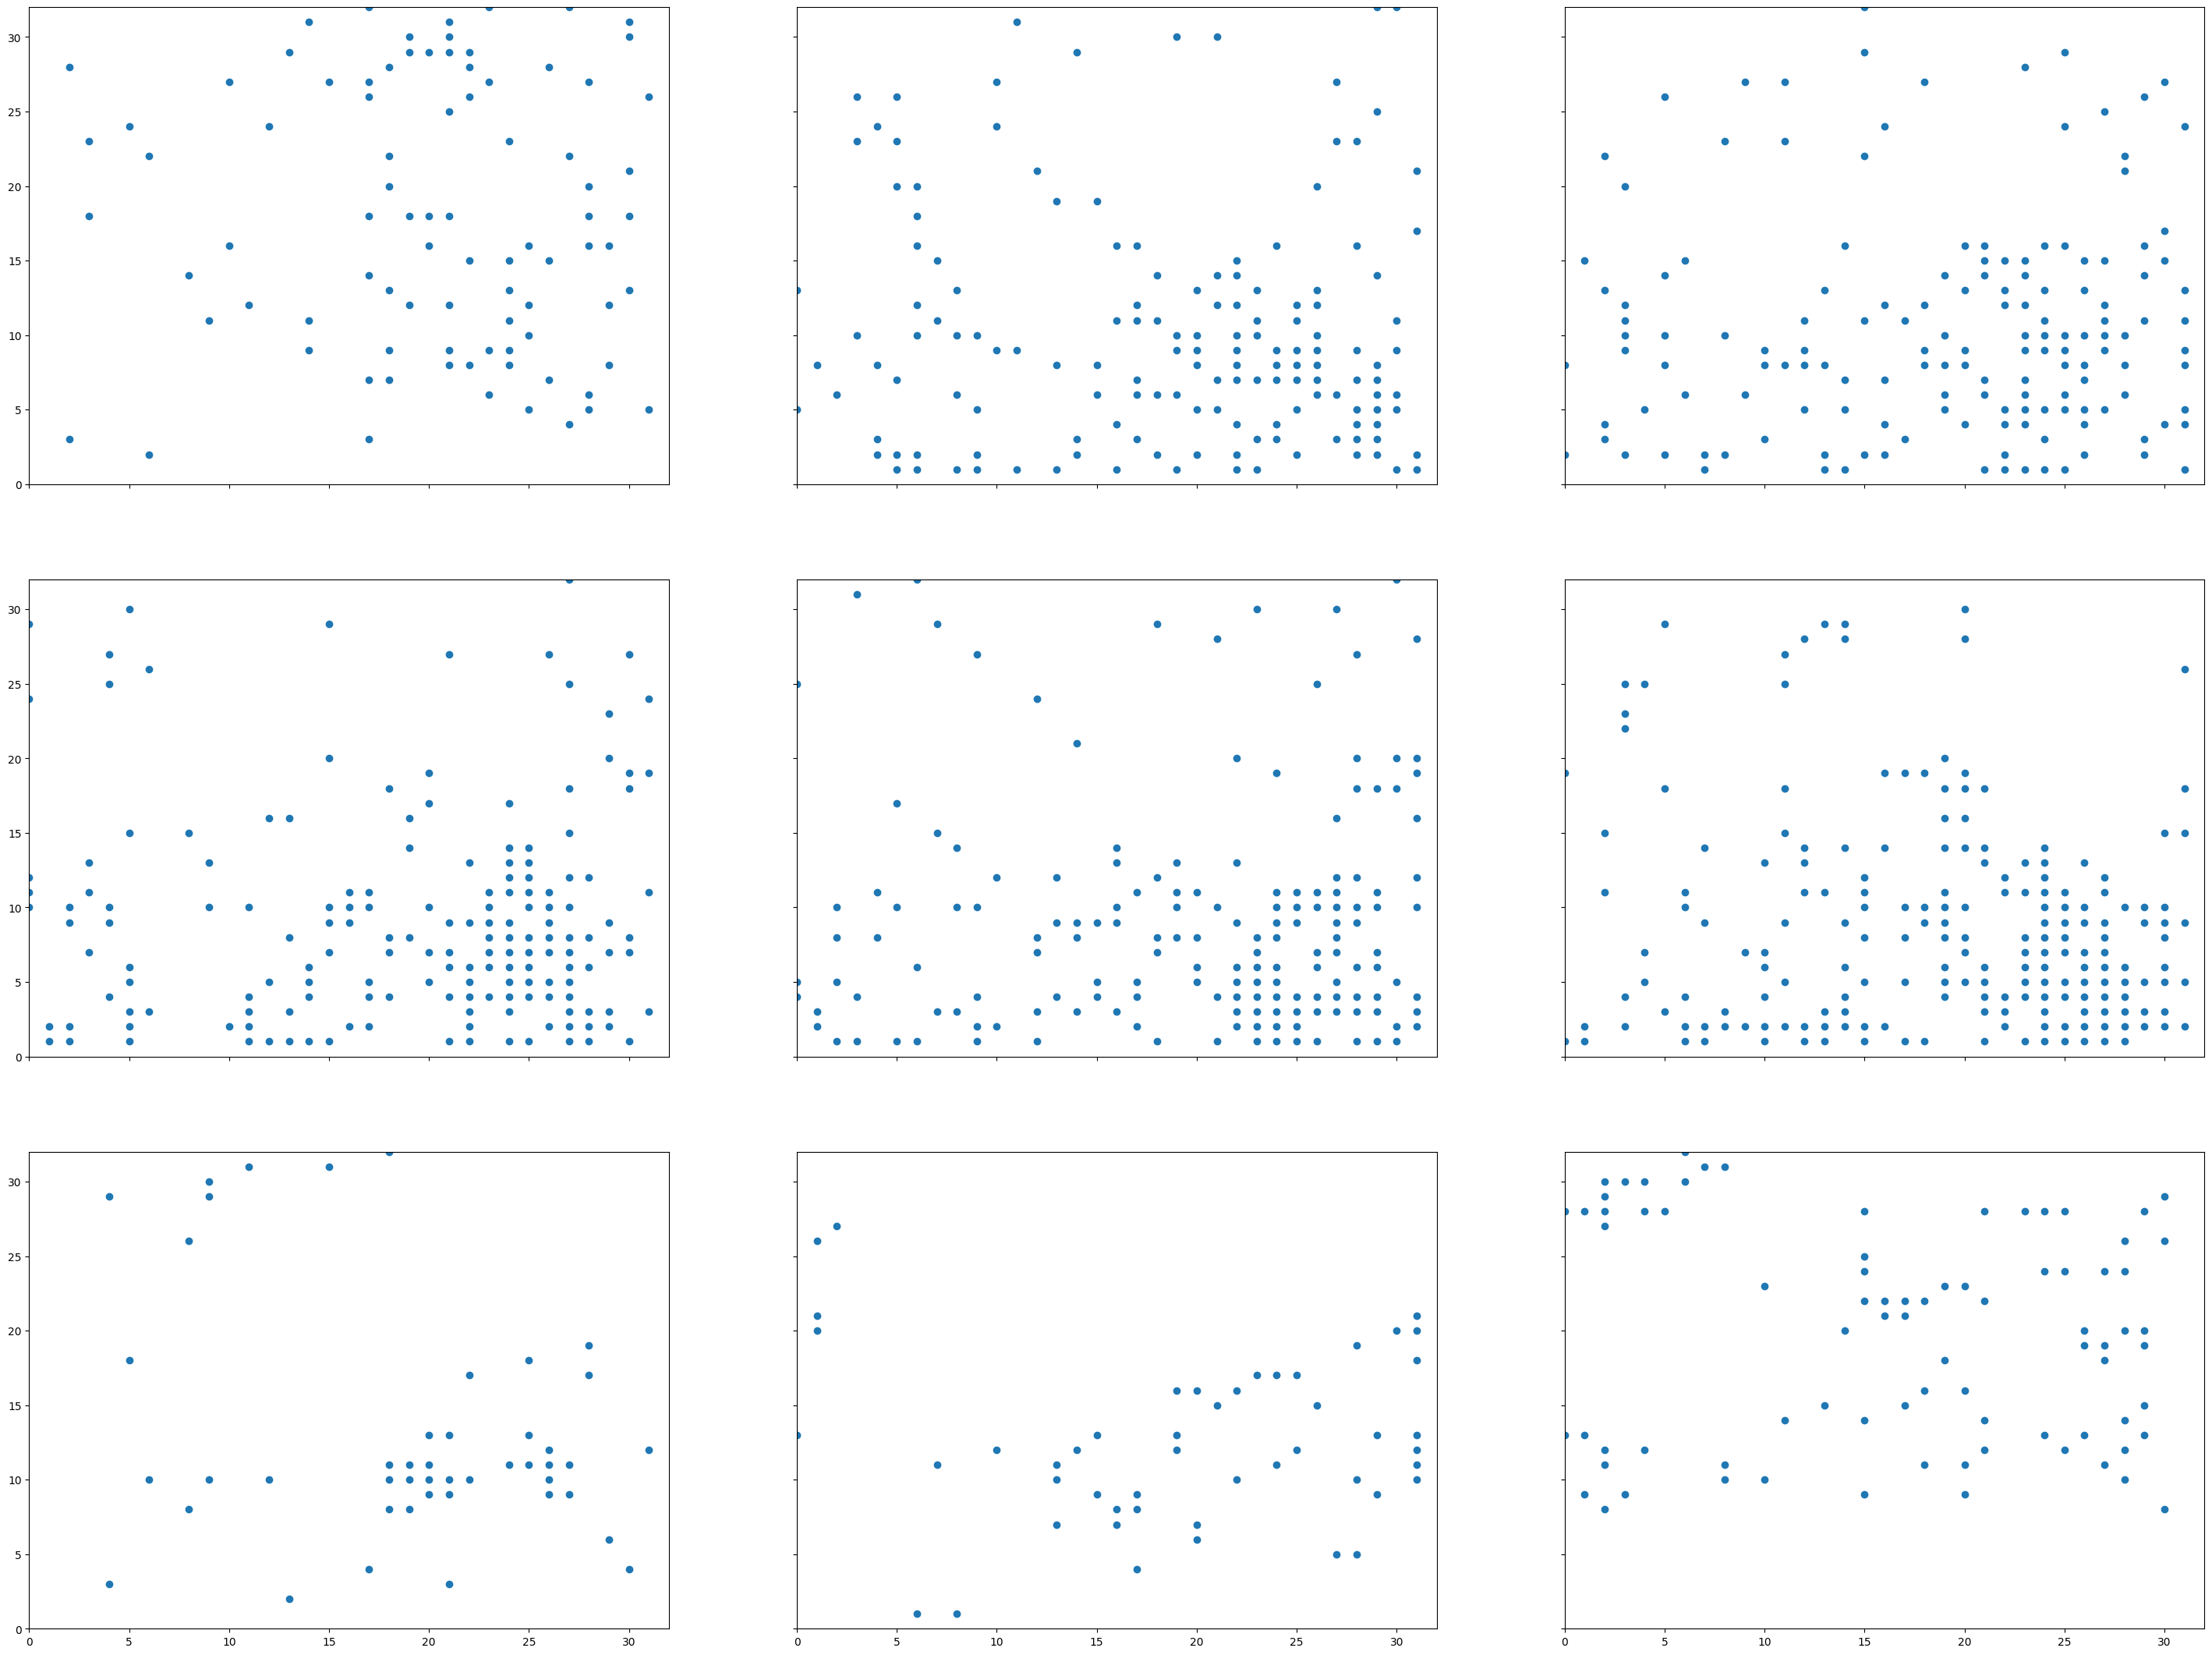

In [8]:
subLevel = 0.8

fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(data_after_noise[i* ncol + j]) > subLevel)
        x = pointcloud[:, 1]
        y = 32 - pointcloud[:, 0]
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 32])
plt.show()

In [9]:
from numpy.linalg import matrix_rank

In [10]:
def are_collinear(coords, tol=None):
    return matrix_rank(coords, tol=tol)==1

def are_sameline(mat):
    x_coordinates = mat[:, 0]
    y_coordinates = mat[:, 1]
    if len(set(x_coordinates)) == 1 or len(set(y_coordinates)) == 1:
        return True
    else:
        return False


def getAlphaExt(pointcloud): # pointcloud defined as list of points in R^2
    nodelst = pointcloud
    G = nx.Graph()
    G.add_edges_from( sp.cKDTree(nodelst).query_pairs(r=1) )

    groupList = []
    for x in nx.connected_components(G):
        groupList.append(list(x))

    regionDict = {}
    R_alpha_dict = {}
    shapeCount = 0
    for i in range(len(groupList)):
        regionDict['group{}'.format(i)] = np.array([nodelst[j] for j in groupList[i]])
        regionDict['group{}'.format(i)][:, 0] = 32 - regionDict['group{}'.format(i)][:, 0]

        #if are_collinear(regionDict['group{}'.format(i)]) == False and len(regionDict['group{}'.format(i)]) > 2:
        if are_sameline(regionDict['group{}'.format(i)]) == False:
            alpha_shape = alphashape.alphashape(regionDict['group{}'.format(i)], 1) # set alpha = 1
            if alpha_shape.geom_type=='Polygon':
                xx, yy = alpha_shape.exterior.coords.xy
                R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                shapeCount += 1

            if alpha_shape.geom_type=='MultiPolygon':
                for ea in alpha_shape.geoms:
                    xx, yy = ea.exterior.coords.xy
                    R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                    shapeCount += 1

    P_alpha_list = []
    region_length_list = []
    for i in range(len(R_alpha_dict)):
        # print (len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
        P_alpha_list = P_alpha_list + list(set(R_alpha_dict['RAlpha{}'.format(i)]))
        region_length_list.append(len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
    P_alpha = np.array(P_alpha_list)

    return P_alpha.tolist(), region_length_list

In [11]:
def getAlphaShapeComplex(pointCloud, regionLengthList): #input R_alpha
    points = [i for i in range(len(pointCloud))]
    tempLengthList = [0] + regionLengthList
    stamp = np.cumsum(tempLengthList)

    tempDict = {}
    simpDict = {}
    for i in range(len(tempLengthList) - 1):
        tempDict['region{}'.format(i)] = points[stamp[i]:stamp[i+1]]
        tempDict['region{}'.format(i)].append(tempDict['region{}'.format(i)][0])

        simpDict['region{}_simp'.format(i)] = []
        for j in range(len(tempDict['region{}'.format(i)])):
            #simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
            if j != len(tempDict['region{}'.format(i)]) - 1:
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j], tempDict['region{}'.format(i)][j+1]])

    f = d.Filtration()
    for i in range(len(simpDict)):
        for vertices in simpDict['region{}_simp'.format(i)]:
            f.append(d.Simplex(vertices))

    return f

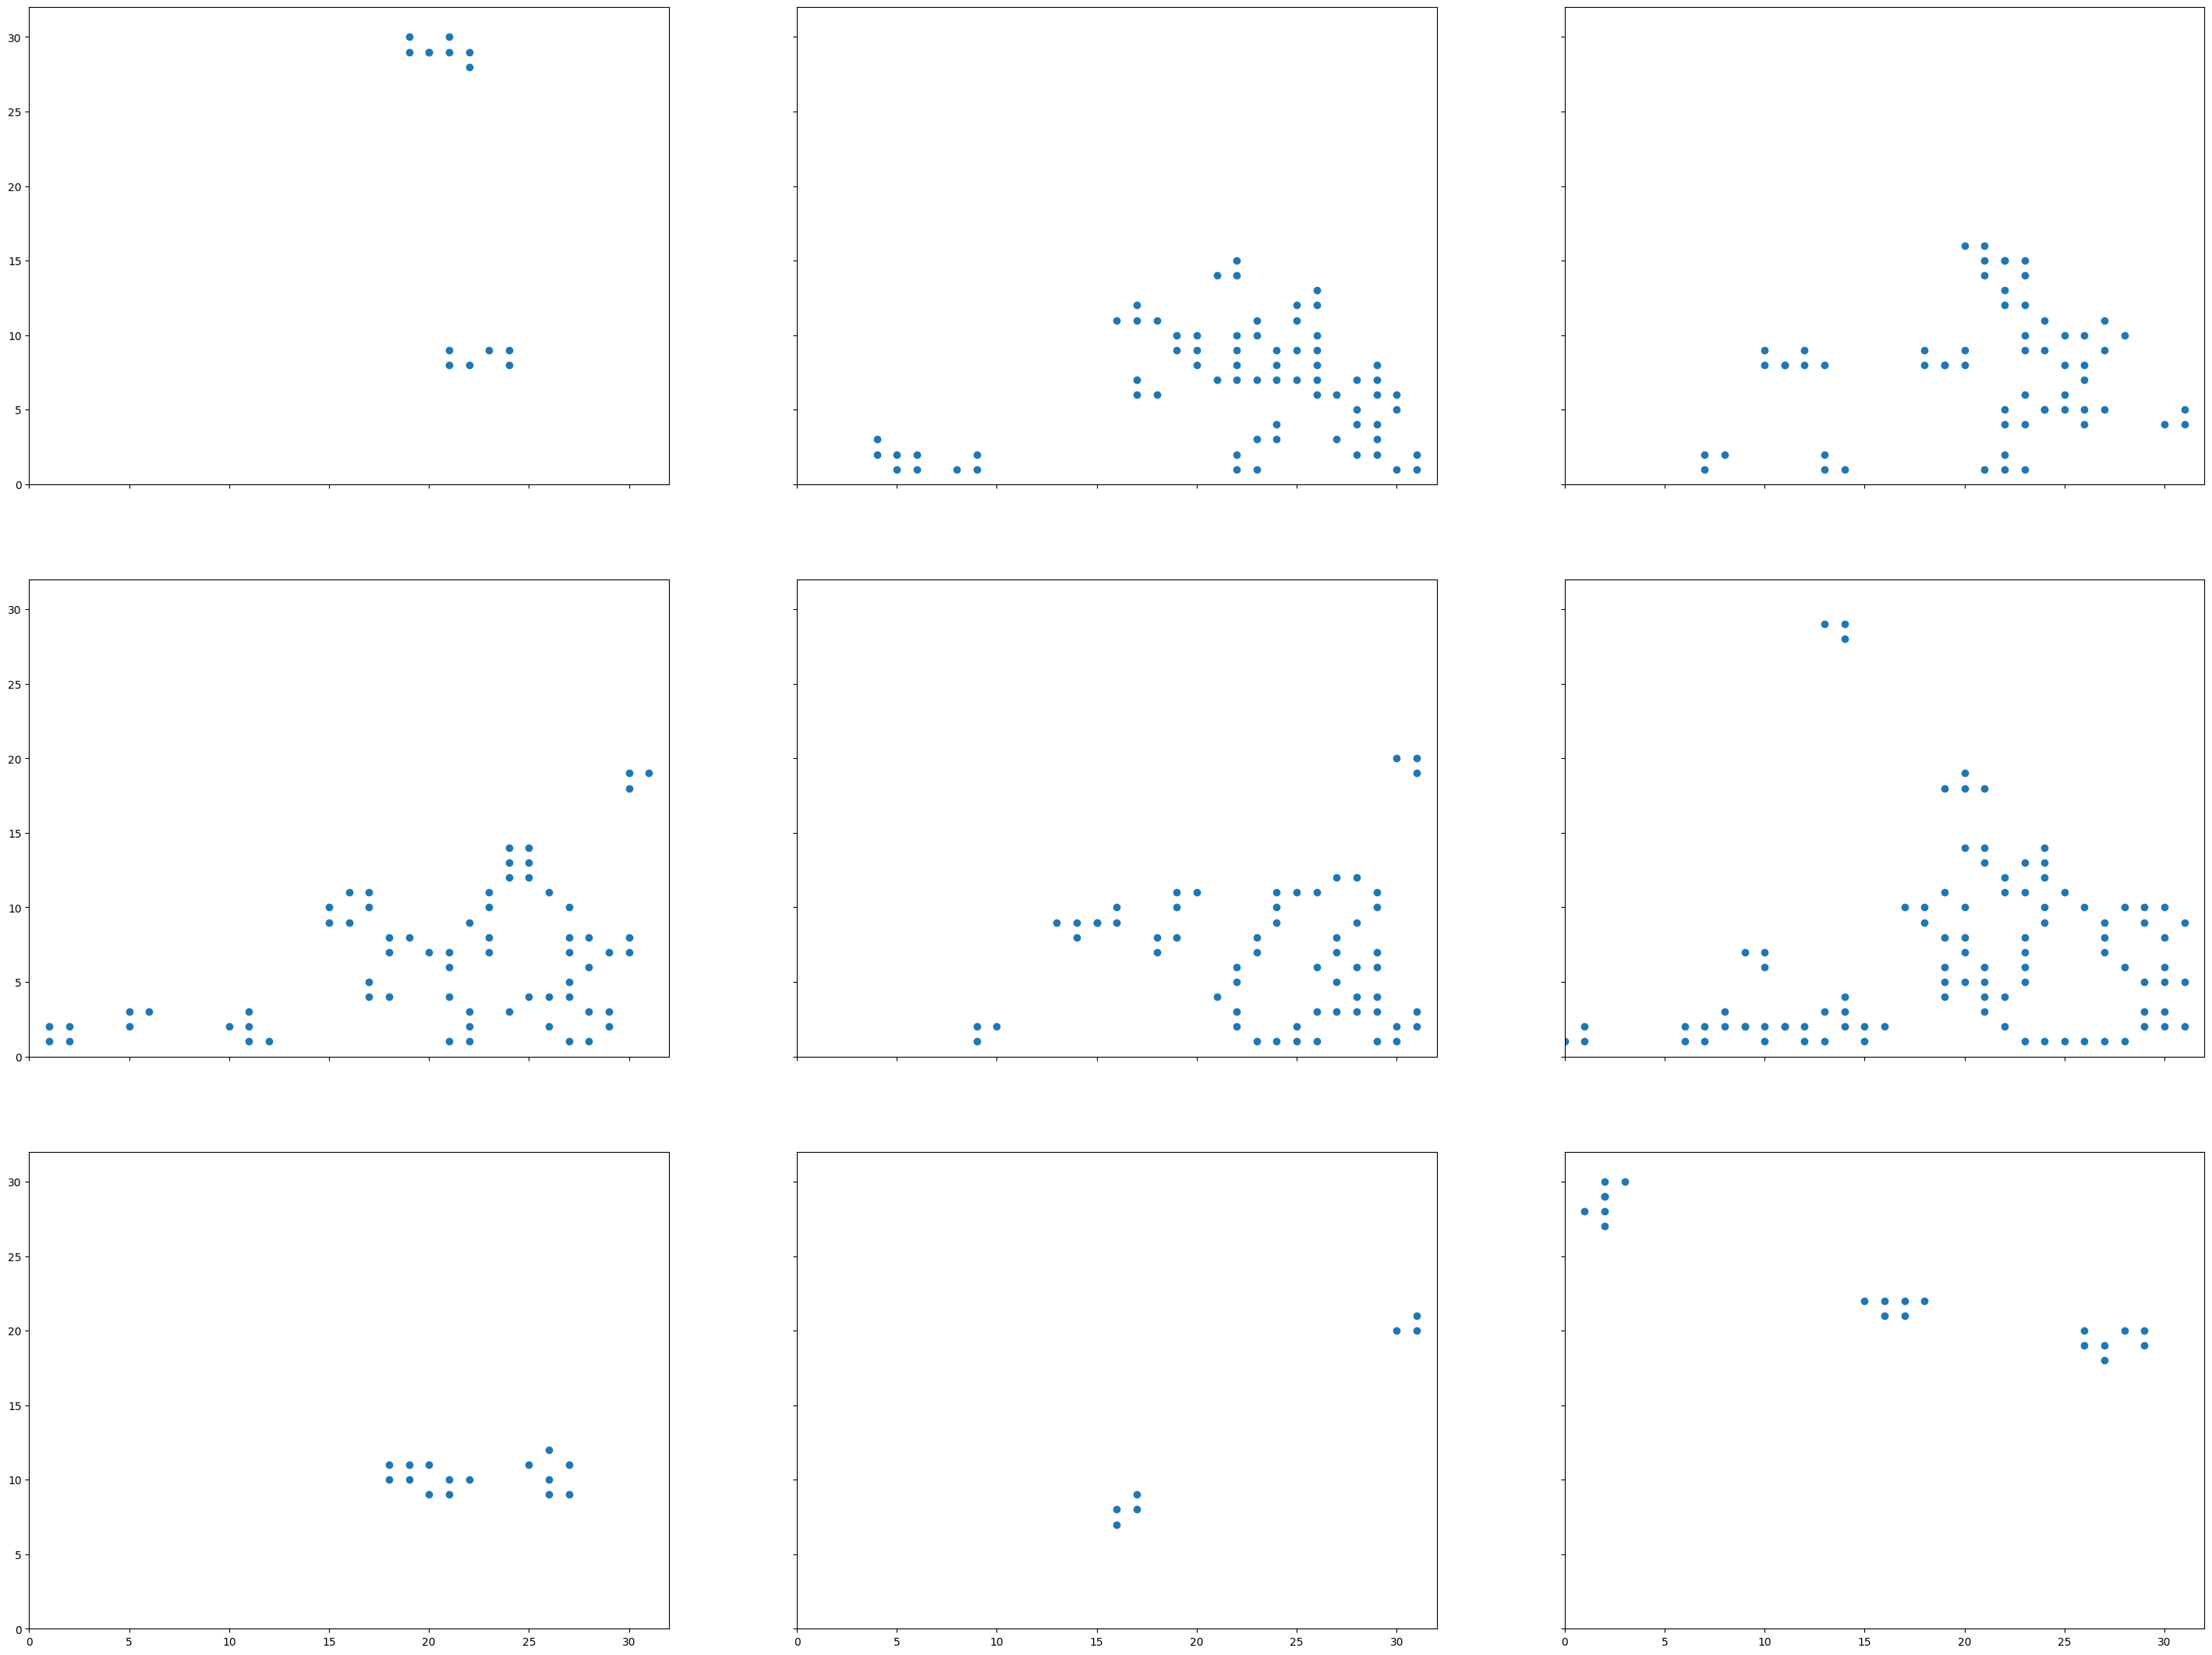

In [12]:
fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))

zigzagDataList = []
regionLengthList = []
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(data_after_noise[i* ncol + j]) > subLevel)
        #pointcloud = np.argwhere(np.array(channel7List[i*ncol + j]) > subLevel)
        P_alpha_list, region_length = getAlphaExt(pointcloud)
        newPtCld = np.array(P_alpha_list)
        if newPtCld.size == 0:
            x = [0]
            y = [0]
            newPtCld = np.array([[0, 0]])
        else:
            x = newPtCld[:, 1]
            y = newPtCld[:, 0]

        zigzagDataList.append(newPtCld)
        regionLengthList.append(region_length)
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 32])

plt.show()

In [13]:
print (len(zigzagDataList))

9


In [14]:
def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def get_verts(simp):
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

tempPtCldLengthList = []
for i in zigzagDataList:
    tempPtCldLengthList.append(len(i))
ptCldLengthList = np.cumsum(tempPtCldLengthList).tolist()
ptCldLengthList = [0] + ptCldLengthList
ptCldLengthList = np.array(ptCldLengthList)

def setup_Zigzag_fixed(lst, r, ptCldLengthList, verbose=False):

    simps_list = []
    times_list = []

    # Initialize A with R(X_0)
    rips = d.fill_rips(lst[0].astype(np.float32), 2, r)
    # rips = getAlphaShapeComplex(lst[0], regionLengthList[0])
    for s in rips:
        s.data = 0.0
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    for i in range(1, len(lst)):
        #print ('Working on number {}'.format(i))
        # Calculate rips of X_{i-1} \cup X_i

        rips = d.fill_rips(np.vstack([lst[i-1], lst[i]]).astype(np.float32), 2, r)
        rips = shift_filtration(rips, ptCldLengthList[i-1])
        for s in rips:
            s.data = 0.0

        # Set of vertices in R(X_i)
        # B = getAlphaShapeComplex(lst[i], regionLengthList[i])
        B = d.fill_rips(lst[i].astype(np.float32), 2, r)
        B = shift_filtration(B, ptCldLengthList[i])
        for s in B:
            s.data = 0.0

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:

            # Get list of vertices of simp
            bdy = get_verts(simp)
            #print ('simp: {}'.format(simp))
            #print ('body:{}'.format(bdy))
            #print ('Simplex {} has vertices {}'.format(simp, bdy))
            # If it has no boundary and its in B, its a vertex in B and has been handled
            if simp in A:
                continue

            elif simp in B:
                continue

            else:
                #if simp not in simps_list:
                M.add(simp)

        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        # Reinitialize for next iteration
        A = B

    filtration = d.Filtration(simps_list)

    #print ('length of time list: {}'.format(len(times_list)))
    #print ('length of simp list: {}'.format(len(simps_list)))
    #print ('length of filtration: {}'.format(len(filtration)))

    return filtration, times_list

In [15]:
from gudhi.representations import Silhouette

In [16]:
def PD2Silhoutte(PD, resolution = 100):
    #SH = gd.representations.Silhouette(resolution=resolution, weight=lambda x: np.power(x[1]-x[0],1))
    SH = Silhouette(resolution=resolution, weight=lambda x: np.power(x[1]-x[0],1))
    sil = SH.fit_transform([PD])[0]
    return sil

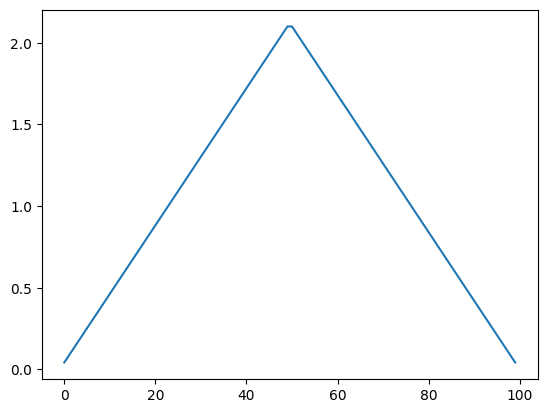

In [17]:
original_PD = np.array([[3.0, 6.0]]) # PD with sublevel = 0.8
vectorized_PD = PD2Silhoutte(original_PD, resolution = 100)

plt.plot(vectorized_PD)
plt.show()

In [18]:
#filtration, times_list = setup_Zigzag_fixed(zigzagDataList, 3, ptCldLengthList)

In [19]:
#d.plot.plot_diagram(dgms[0], show = True)
#zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)
#d.plot.plot_diagram(dgms[1], show = True)

In [20]:
#birth1=np.array([dgm.birth for dgm in dgms[1]])
#death1=np.array([dgm.death for dgm in dgms[1]])

#noised_PD = np.array([list(i) for i in zip(birth1, death1)])
#original_PD = np.array([[3.0, 6.0]])

#print (wd(noised_PD, original_PD))

In [31]:
count = 0
subLevel  = 0.8
#original_PD = np.array([[0.5, 6.0], [1.0, 1.5], [2.5, 6.0], [2.5, 4.0]]) # PD with sublevel = 0.7
original_PD = np.array([[2.5, 5.5],
                        [5. , 5.5],
                        [3.0, 6.0]]) # PD with sublevel = 0.8
vectorized_PD = PD2Silhoutte(original_PD, resolution = 100)
N = 100
noise = 0.01
anomaly_check = []
wassDisList = []
noised_PD_List = []
SilList = []
L2DisList = []

while count < N:
    print ('Progress: {:.2f}'.format((count + 1)/N))
    data_after_noise = []
    for i in range(nrow):
        for j in range(ncol):
            matrix = np.random.normal(loc=0.0, scale = noise, size=(32, 32)) # 32 change to width and length  of input image later
            data_after_noise.append(channel7List[i* ncol + j] + matrix)
            #data_after_noise.append(channel7List[i* ncol + j] ) # test no noise

    zigzagDataList = []
    regionLengthList = []
    for i in range(nrow):
        for j in range(ncol):
            pointcloud = np.argwhere(np.array(data_after_noise[i* ncol + j]) > subLevel)
            P_alpha_list, region_length = getAlphaExt(pointcloud)
            newPtCld = np.array(P_alpha_list)
            if newPtCld.size == 0:
                newPtCld = np.array([[0, 0]])
            else:
                pass
            zigzagDataList.append(newPtCld)
            regionLengthList.append(region_length)

    tempPtCldLengthList = []
    for i in zigzagDataList:
        tempPtCldLengthList.append(len(i))
    ptCldLengthList = np.cumsum(tempPtCldLengthList).tolist()
    ptCldLengthList = [0] + ptCldLengthList
    ptCldLengthList = np.array(ptCldLengthList)

    filtration, times_list = setup_Zigzag_fixed(zigzagDataList, 3, ptCldLengthList)
    zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    noised_PD = np.array([list(i) for i in zip(birth1, death1)])
    vectorized_noised_PD = PD2Silhoutte(noised_PD, resolution = 100)
    SilList.append(vectorized_noised_PD)

    L2Dis = np.linalg.norm(vectorized_PD - vectorized_noised_PD, 2)
    L2DisList.append(L2Dis)

    noised_PD_List.append(noised_PD)
    wassDisList.append(wd(original_PD, noised_PD))
    #print (noised_PD)
    if [3.0, 6.] in noised_PD.tolist():
        anomaly_check.append('Yes')
    else:
        anomaly_check.append('No')

    count += 1

print (wassDisList, len(wassDisList))
print (anomaly_check, len(anomaly_check))

Progress: 0.01
Progress: 0.02
Progress: 0.03
Progress: 0.04
Progress: 0.05
Progress: 0.06
Progress: 0.07
Progress: 0.08
Progress: 0.09
Progress: 0.10
Progress: 0.11
Progress: 0.12
Progress: 0.13
Progress: 0.14
Progress: 0.15
Progress: 0.16
Progress: 0.17
Progress: 0.18
Progress: 0.19
Progress: 0.20
Progress: 0.21
Progress: 0.22
Progress: 0.23
Progress: 0.24
Progress: 0.25
Progress: 0.26
Progress: 0.27
Progress: 0.28
Progress: 0.29
Progress: 0.30
Progress: 0.31
Progress: 0.32
Progress: 0.33
Progress: 0.34
Progress: 0.35
Progress: 0.36
Progress: 0.37
Progress: 0.38
Progress: 0.39
Progress: 0.40
Progress: 0.41
Progress: 0.42
Progress: 0.43
Progress: 0.44
Progress: 0.45
Progress: 0.46
Progress: 0.47
Progress: 0.48
Progress: 0.49
Progress: 0.50
Progress: 0.51
Progress: 0.52
Progress: 0.53
Progress: 0.54
Progress: 0.55
Progress: 0.56
Progress: 0.57
Progress: 0.58
Progress: 0.59
Progress: 0.60
Progress: 0.61
Progress: 0.62
Progress: 0.63
Progress: 0.64
Progress: 0.65
Progress: 0.66
Progress: 

In [32]:
mean = np.mean(wassDisList)
print (mean)

0.6


In [33]:
import scipy.stats as st

Text(0.5, 1.0, 'Histogram Noise = 1.00%')

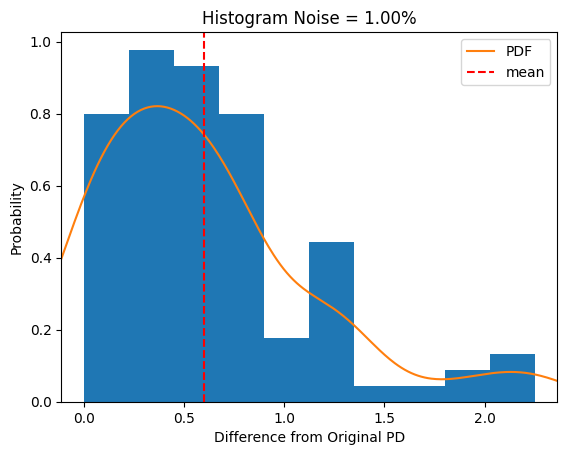

In [34]:
q25, q75 = np.percentile(wassDisList, [25, 75])
bin_width = 2 * (q75 - q25) * len(wassDisList) ** (-1/3)
bins = round((max(wassDisList)- min(wassDisList)) / bin_width)
mean = np.mean(wassDisList)

plt.hist(wassDisList, density=True, bins=bins)  # density=False would make counts
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(wassDisList)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.axvline(mean, color='red', linestyle='dashed', label = 'mean')
plt.legend(loc="upper right")
plt.ylabel("Probability")
plt.xlabel("Difference from Original PD")
plt.title("Histogram Noise = {:.2%}".format(noise))

In [35]:
anomaly_check.count('No')/N

0.0